In [1]:
import glob
import random
import h5py
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

Find data files recursively from root folder.

In [2]:
data_path = "D:/Coding/Thesis/Data/STFT Output/**/*.h5"
data_files = glob.glob(data_path, recursive=True)

In [3]:
config = {}

config['EEG_window_length_in_ms'] = 30000

Next, we configure the output layer of the LSTM:


`delta_time_k` predicts the delta time to the next $k^{th}$ tap.

`tap_count_times_p` predicts the *number of taps* within the next $p$ seconds.

In [4]:
config['delta_time_k'] = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
config['tap_count_times_p'] = np.array([0.5, 1, 5, 10, 50, 100, 500])

config['EEG_sampling_rate'] = 1000
config['stft_stride'] = 32
config['sampling_rate_after_stft'] = config['EEG_sampling_rate'] / config['stft_stride']
config['sample_length_after_stft'] = 1000 / config['sampling_rate_after_stft']

config['tap_count_times_in_samples'] = np.multiply(config['tap_count_times_p'], config['EEG_sampling_rate'])

# The ParticipantData class
The ParticipantData class contains and acts on participant data. It knows about the structure of the h5 files and can return random windows of EEG activity and taps, i.e., training data.

The stft data in the h5 files is 3-dimensional:
1. EEG channel
2. EEG timeseries
3. STFT frequency bins

# Load data into memory

Instead of loading data from the h5 file when we need it, we load all the data of a single participant into memory (because it fits and it's easier)

In [5]:
def load_data(h5_files):
    EEG, taps = [], []
    
    # Makse sure that if a single file is passed in, it is put into a list
    if type(h5_files) != 'list':
        h5_files = [h5_files]
    
    for f in h5_files:
        with h5py.File(f, 'r') as f_open:        
            for session in list(f_open.keys()):
                for activity_window in list(f_open[session].keys()):
                    EEG.append(np.array(f_open[session][activity_window]['stft']))
                    taps.append(np.array(f_open[session][activity_window]['taps']))
        
    return (EEG, taps)

In [6]:
%time stft, taps = load_data(data_files[0])

Wall time: 31.5 s


### Replacing ParticipantData class with class inherited from `tf.keras.utils.Sequence`

In [7]:
class DataLoader(keras.utils.Sequence):
    def __init__(self, x, y, window_length=30000, batch_size=32, n_samples=2000, shuffle=True):
        self.x = x
        self.y = y
        self.window_length = window_length
        self.batch_size = batch_size
        self.n_samples = n_samples
        self.shuffle = shuffle
        
        self.subset_probabilities = self._get_subset_probabilites(x)
    
    
    def __len__(self):
        return sum([win.shape[1] for win in x])
    
    
    def __getitem__(self, index=0):
        X = []
        Y = []
        
        for batch in range(self.batch_size):
            if self.shuffle:
                # Pick random activity window
                # Since subsets are of different length and contain different amounts of data,
                # we need to adjust the probability of each subset being picked to its length.
                subset_idx = np.random.choice(len(self.x), p = self.subset_probabilities)

                # Pick random EEG window
                window_length_in_samples = np.ceil(self.window_length / config['stft_stride']).astype(np.int)

                window_end_idx = np.random.randint(window_length_in_samples, self.x[subset_idx].shape[1])       
                window_idx_stft = np.arange(window_end_idx - window_length_in_samples, window_end_idx, dtype=np.int)        

                input_data = np.array(self.x[subset_idx][:, window_idx_stft, :])
                
                # Get appropriate tap info        
                window_end_idx_tap_adjusted = np.ceil(np.array(window_end_idx) * config['sampling_rate_after_stft']).astype(np.int)

                output_data = self.get_taps_in_window(self.y[subset_idx], window_end_idx_tap_adjusted)
            else:
                subset_idx = 0 # TODO Change this as soon as I know how and when __getitem__ is called during the fit and test stage
                
                # EEG data
                window_length_in_samples = np.ceil(self.window_length / config['stft_stride']).astype(np.int)
                window_idx_stft = np.arange(index - window_length_in_samples, index, dtype=np.int)
                input_data = np.array(self.x[subset_idx][:, window_idx_stft, :])
                
                # Tap data
                window_end_idx_tap_adjusted = np.ceil(np.array(index) * config['sampling_rate_after_stft']).astype(np.int)
                output_data = self.get_taps_in_window(self.y[subset_idx], window_end_idx_tap_adjusted)
            
            input_data = np.moveaxis(input_data, 1, 0)
            
            X.append(input_data)
            Y.append(output_data)
                
        return X, Y
    
    def on_epoch_end(self):
        pass
    
    def _get_subset_probabilites(self, x):
        lengths = np.array([win.shape[1] for win in x])
        
        return lengths / sum(lengths)
        
    
    def get_taps_in_window(self, taps, window_end):      
        tap_deltas = self.get_delta_taps(taps, window_end)
        
        future_tap_n = self.get_n_future_taps(taps, window_end)
        
        result = np.concatenate((tap_deltas, future_tap_n))

        return result 
    
    
    def get_delta_taps(self, taps, window_idx):
        n_k = len(config['delta_time_k'])
        
        next_kth_taps = taps[taps > window_idx][:n_k]
        
        # Ensure that if not enough taps were found the array is padded with 0s.
        # This only occurs 
        if len(next_kth_taps) < n_k:
            next_kth_taps = np.concatenate((next_kth_taps, np.zeros(n_k - len(next_kth_taps))))
        
        tap_deltas = next_kth_taps - window_idx
        
        return tap_deltas
            
    
    def get_n_future_taps(self, taps, window_idx):
        n_future_taps = np.zeros(len(config['tap_count_times_in_samples']))
        
        for p_idx, p in enumerate(config['tap_count_times_in_samples']):
            n_future_taps[p_idx] = len(
                taps[
                    (taps > window_idx) &
                    (taps <= (window_idx + p))
                ]
            )
        
        return n_future_taps

# Determining the in- and outputs of the LSTM
Next, we check the sizes that are returned by our data generation function.

In [8]:
ppt1 = DataLoader(stft, taps, batch_size=8)

In [10]:
my_batch_x, my_batch_y = ppt1[0] # get a random batch

And do a sanity check on the content of the generated target data.

Input layer dimensions: (938, 64, 32)
Output layer dimensions: (17,)
Output layer values: [  934.  2422.  3808.  5376.  7608. 12215. 14880. 15934. 16941. 18272.
     0.     1.     3.     5.    27.    58.   270.]


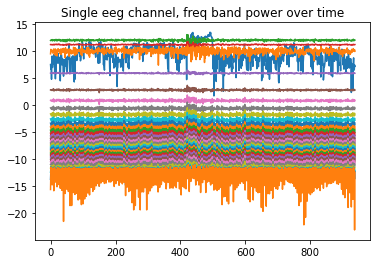

In [150]:
np.set_printoptions(suppress=True)

print(f'Input layer dimensions: {my_batch_x[0].shape}')
print(f'Output layer dimensions: {my_batch_y[0].shape}')
print(f'Output layer values: {my_batch_y[0]}')

plt.plot(my_batch_x[0][:, 0, :])
plt.title('Single eeg channel, freq band power over time')
plt.show()


## Input layer
The ParticipantData class generates an input information that is $64 \times 938 \times 32$ in size. Since the second dimension is the temporal information, the LSTM's input layer has a size of $64 \times 32 = 2048$ and takes a window of 938 samples at a time.

This conversion from window length in ms to window length in STFT samples can be calculated by the following formula:

$$
\bigl\lceil
\frac{\frac{\text{T}}{1000} \text{Fs}}
{\text{R}}
\bigr\rceil
$$

, where $T$ is the window length in ms, $Fs$ is the original sampling rate, and $R$ is the hopsize of the STFT.

## Output layer
The ParticipantData class also generates training output. The output layer has a length of 17. It is composed of the $\Delta t$ to the next $k$ steps in ms, as well as the number of taps within the next $p$ seconds. Which and how many $k$ and $p$ are predicted is defined in the config dictionary at the top of the script. The size of the output layer is defined as $|K| + |P|$

# LSTM
## Configure LSTM

In [168]:
LSTM_config = {
    'input_layer_size': np.prod(np.array(my_batch_x[0].shape)[[0, 2]]),
    'output_layer_size': my_batch_y[0].shape[0]
}

model = keras.Sequential()

model.add(keras.Input(shape=(LSTM_config['input_layer_size'], 1)))
model.add(layers.LSTM(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(LSTM_config['output_layer_size']))

model.summary()

model.compile(loss='mean_squared_error', optimizer='adam')

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 17)                2193      
Total params: 68,753
Trainable params: 68,753
Non-trainable params: 0
_________________________________________________________________


## Fit a single model

In [ ]:
model.fit_generator()